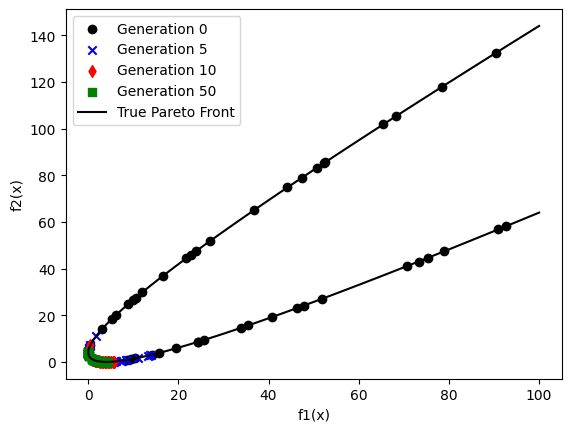

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class DifferentialEvolution:
    def __init__(self, pop_size, bounds, generations, F, CR):
        self.pop_size = pop_size
        self.bounds = bounds
        self.generations = generations
        self.F = F
        self.CR = CR
        self.population = self.initialize_population()
        self.objective_values = self.evaluate_population(self.population)

    # Initialize the population with random values within the bounds
    def initialize_population(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], self.pop_size)

    # Define the objective functions
    @staticmethod
    def f1(x):
        return x ** 2

    @staticmethod
    def f2(x):
        return (x - 2) ** 2

    # Evaluate the population by calculating the objective function values for each individual
    def evaluate_population(self, population):
        return np.array([[self.f1(x), self.f2(x)] for x in population])

    # Perform mutation to generate mutant vectors
    def mutate(self):
        mutants = np.zeros_like(self.population)
        for i in range(self.pop_size):
            indices = np.random.choice(self.pop_size, 3, replace=False)
            while i in indices:
                indices = np.random.choice(self.pop_size, 3, replace=False)
            x1, x2, x3 = self.population[indices]
            mutants[i] = x1 + self.F * (x2 - x3)
        return mutants

    # Perform crossover to generate trial vectors
    def crossover(self, mutants):
        trial_vectors = np.zeros_like(self.population)
        for i in range(self.pop_size):
            rand_idx = np.random.randint(0, 1)
            if np.random.rand() < self.CR or rand_idx == 0:
                trial_vectors[i] = mutants[i]
            else:
                trial_vectors[i] = self.population[i]
        return trial_vectors

    # Apply reflection boundary control to keep trial vectors within bounds
    def reflect_bounds(self, trial_vectors):
        trial_vectors = np.where(trial_vectors < self.bounds[0], 2 * self.bounds[0] - trial_vectors, trial_vectors)
        trial_vectors = np.where(trial_vectors > self.bounds[1], 2 * self.bounds[1] - trial_vectors, trial_vectors)
        return trial_vectors

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def dominates(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select(self, trial_vectors, trial_objective_values):
        new_population = []
        new_objective_values = []
        for i in range(self.pop_size):
            if self.dominates(trial_objective_values[i], self.objective_values[i]):
                new_population.append(trial_vectors[i])
                new_objective_values.append(trial_objective_values[i])
            else:
                new_population.append(self.population[i])
                new_objective_values.append(self.objective_values[i])
        self.population = np.array(new_population)
        self.objective_values = np.array(new_objective_values)

    # Plot the population in the objective space
    @staticmethod
    def plot_population(objective_values, gen, color, marker):
        plt.scatter(objective_values[:, 0], objective_values[:, 1], c=color, label=f'Generation {gen}', marker=marker)

    # Main loop to run the Differential Evolution algorithm
    def run(self):
        # Plot initial population
        self.plot_population(self.objective_values, 0, 'black', 'o')

        for gen in range(1, self.generations + 1):
            mutants = self.mutate()
            trial_vectors = self.crossover(mutants)
            trial_vectors = self.reflect_bounds(trial_vectors)
            trial_objective_values = self.evaluate_population(trial_vectors)
            self.select(trial_vectors, trial_objective_values)

            if gen in [5, 10, 50]:
                if gen == 5:
                    self.plot_population(self.objective_values, gen, 'blue', 'x')
                elif gen == 10:
                    self.plot_population(self.objective_values, gen, 'red', 'd')
                elif gen == 50:
                    self.plot_population(self.objective_values, gen, 'green', 's')

        # Plot true Pareto front
        x = np.linspace(self.bounds[0], self.bounds[1], 100)
        plt.plot(self.f1(x), self.f2(x), 'k-', label='True Pareto Front')
        plt.xlabel('f1(x)')
        plt.ylabel('f2(x)')
        plt.legend()
        plt.savefig("pareto",bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
pop_size = 50
bounds = [-10, 10]
generations = 50
F = 0.8
CR = 0.9

# Create an instance of the DifferentialEvolution class and run the algorithm
de = DifferentialEvolution(pop_size, bounds, generations, F, CR)
de.run()



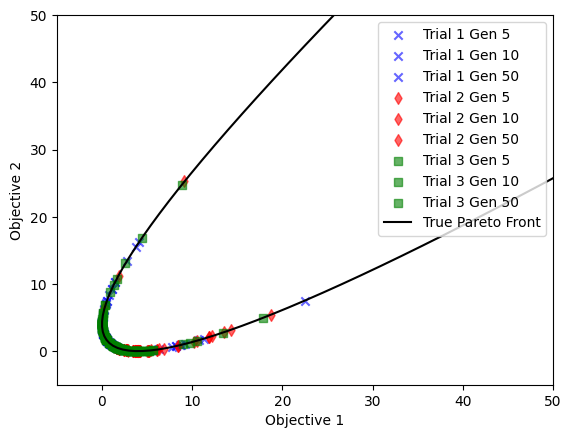

In [25]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, search_bounds, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.search_bounds = search_bounds
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.search_bounds[0], self.search_bounds[1], self.population_size)

    # Define the objective functions
    @staticmethod
    def objective1(x):
        return x ** 2

    @staticmethod
    def objective2(x):
        return (x - 2) ** 2

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    # Perform mutation to create mutant vectors
    def create_mutants(self, candidates):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 3, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 3, replace=False)
            a, b, c = candidates[indices]
            mutants[i] = a + self.mutation_factor * (b - c)
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            random_index = np.random.randint(0, 1)
            if np.random.rand() < self.crossover_rate or random_index == 0:
                trials[i] = mutants[i]
            else:
                trials[i] = candidates[i]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.where(trials < self.search_bounds[0], 2 * self.search_bounds[0] - trials, trials)
        trials = np.where(trials > self.search_bounds[1], 2 * self.search_bounds[1] - trials, trials)
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)

            # Save objective values at specific generations for analysis
            if generation in [5, 10, 50]:
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm and plot the results
    def run_and_compare_trials(self, num_trials=3):
        colors = ['blue', 'red', 'green']
        markers = ['x', 'd', 's']
        trials_data = []

        for trial in range(num_trials):
            trial_data = list(self.execute_trial())
            trials_data.append(trial_data)

        for trial_index, trial_data in enumerate(trials_data):
            for generation, candidate_values in trial_data:
                label = f'Trial {trial_index + 1} Gen {generation}'
                color = colors[trial_index]
                marker = markers[trial_index]
                self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(self.search_bounds[0], self.search_bounds[1], 100)
        plt.plot(self.objective1(x_values), self.objective2(x_values), 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(-5, 50)  # Set x-axis limits to zoom in
        plt.ylim(-5, 50)  # Set y-axis limits to zoom in
        plt.savefig("pareto_trials_zoomed", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 50
search_bounds = [-10, 10]
num_generations = 50
mutation_factor = 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class and run multiple trials
de_instance = MultiObjectiveDE(population_size, search_bounds, num_generations, mutation_factor, crossover_rate)
de_instance.run_and_compare_trials(num_trials=3)


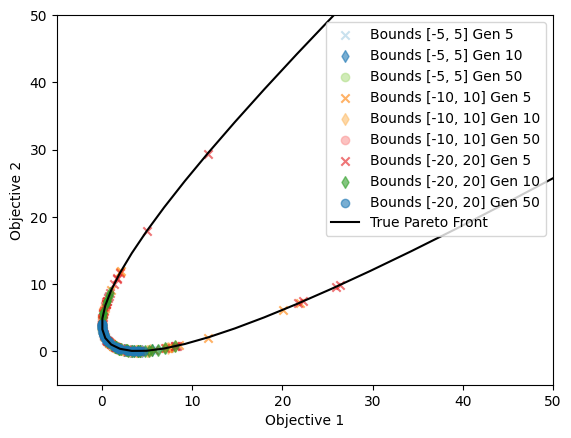

In [27]:
#PROBLEM 3 PART 4
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, search_bounds, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.search_bounds = search_bounds
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.search_bounds[0], self.search_bounds[1], self.population_size)

    # Define the objective functions
    @staticmethod
    def objective1(x):
        return x ** 2

    @staticmethod
    def objective2(x):
        return (x - 2) ** 2

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    # Perform mutation to create mutant vectors
    def create_mutants(self, candidates):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 3, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 3, replace=False)
            a, b, c = candidates[indices]
            mutants[i] = a + self.mutation_factor * (b - c)
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            random_index = np.random.randint(0, 1)
            if np.random.rand() < self.crossover_rate or random_index == 0:
                trials[i] = mutants[i]
            else:
                trials[i] = candidates[i]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.where(trials < self.search_bounds[0], 2 * self.search_bounds[0] - trials, trials)
        trials = np.where(trials > self.search_bounds[1], 2 * self.search_bounds[1] - trials, trials)
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)

            # Save objective values at specific generations for analysis
            if generation in [5, 10, 50]:
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm with different parameter ranges and plot the results
    def run_and_compare_ranges(self, ranges, num_trials=1):
        for idx, search_bounds in enumerate(ranges):
            self.search_bounds = search_bounds

            if idx == 0:
                colors = ['#A6CEE3', '#1F78B4', '#B2DF8A']  # Faded colors
            elif idx == 1:
                colors = ['#FF7F00', '#FDBF6F', '#FB9A99']  # Bright summer colors
            elif idx == 2:
                colors = ['#E31A1C', '#33A02C', '#1F78B4']  # Classic red, green, and blue

            for trial in range(num_trials):
                trial_data = list(self.execute_trial())
                for generation, candidate_values in trial_data:
                    label = f'Bounds {search_bounds} Gen {generation}'
                    color = colors[0] if generation == 5 else colors[1] if generation == 10 else colors[2]
                    marker = 'x' if generation == 5 else 'd' if generation == 10 else 'o'
                    self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(-20, 20, 100)
        plt.plot(self.objective1(x_values), self.objective2(x_values), 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(-5, 50)  # Set x-axis limits to zoom in
        plt.ylim(-5, 50)  # Set y-axis limits to zoom in
        plt.savefig("pareto_34", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 50
num_generations = 50
mutation_factor = 0.8
crossover_rate = 0.9
parameter_ranges = [[-5, 5], [-10, 10], [-20, 20]]

# Create an instance of the MultiObjectiveDE class and run trials with different parameter ranges
de_instance = MultiObjectiveDE(population_size, None, num_generations, mutation_factor, crossover_rate)
de_instance.run_and_compare_ranges(parameter_ranges, num_trials=1)

